In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.utils import plot_model
import numpy as np
import os

C:\Users\Misha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BATCH_SIZE = 512
EPOCHS = 20
LEARNING_RATE = 0.001

# Preparing train and test datasets

In [10]:
(train_data, val_data, test_data), metadata = tfds.load('binary_alpha_digits',
                                                        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                        with_info=True)
print(metadata.features)


FeaturesDict({
    'image': Image(shape=(20, 16, 1), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=36),
})


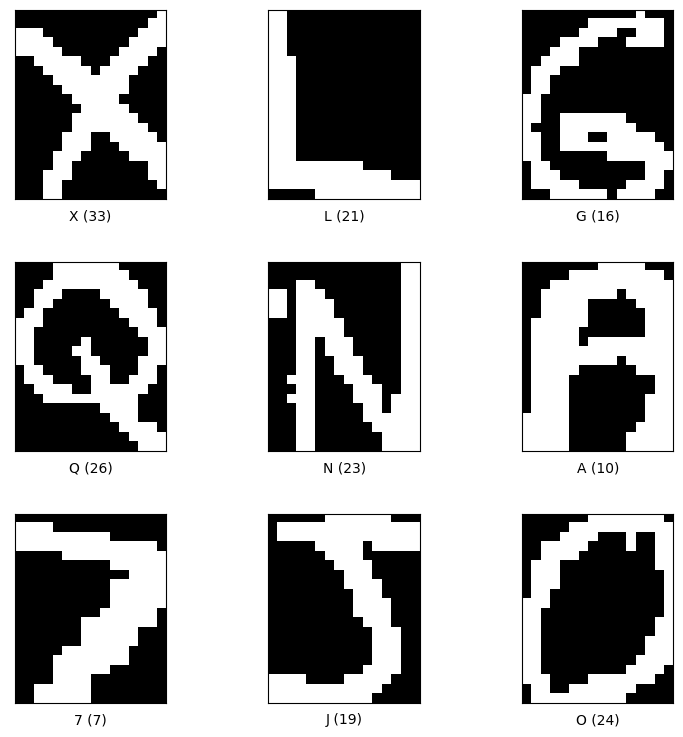

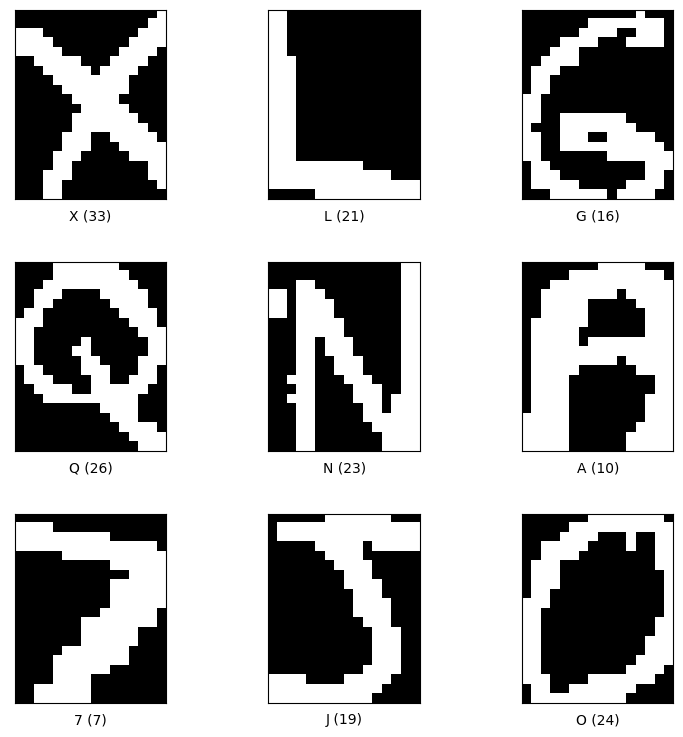

In [11]:
tfds.visualization.show_examples(train_data, metadata)

In [13]:
def preprocess(dataset):
    image = tf.cast(dataset['image'], dtype=tf.float32) / 255.
    label = tf.cast(dataset['label'], dtype=tf.float32)
    return image, label

train_data = train_data.map(preprocess).shuffle(buffer_size=1024).batch(BATCH_SIZE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE)

TypeError: in user code:


    TypeError: tf__preprocess() takes 1 positional argument but 2 were given


# Defining Classification Model

In [14]:
def simple_convolution_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(20, 16, 1 ,))
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(2, 2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.models.Model(input_, output_, name='Classifier')

def simple_mlp_model(num_classes):
    input_ = tf.keras.layers.Input(shape=(160, 160, 3,))
    x = tf.keras.layers.Flatten()(input_)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_ = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.models.Model(input_, output_, name='Classifier')

num_classes = metadata.features['label'].num_classes
model = simple_convolution_model(num_classes)
model.summary()

Model: "Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 16, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 20, 16, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 8, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 8, 64)         18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 8, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 4, 128)        0         
 2D)                                                    

# Training model

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001,
                                                             decay_steps=100000,
                                                             decay_rate=0.96)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
3/3 [==============================] - 5s 749ms/step - loss: 3.5838 - accuracy: 0.0232 - val_loss: 3.5839 - val_accuracy: 0.0142
Epoch 2/20
3/3 [==============================] - 2s 630ms/step - loss: 3.5835 - accuracy: 0.0294 - val_loss: 3.5840 - val_accuracy: 0.0426
Epoch 3/20
3/3 [==============================] - 3s 864ms/step - loss: 3.5834 - accuracy: 0.0267 - val_loss: 3.5844 - val_accuracy: 0.0142
Epoch 4/20
3/3 [==============================] - 2s 581ms/step - loss: 3.5832 - accuracy: 0.0294 - val_loss: 3.5847 - val_accuracy: 0.0142
Epoch 5/20
3/3 [==============================] - 2s 512ms/step - loss: 3.5831 - accuracy: 0.0303 - val_loss: 3.5852 - val_accuracy: 0.0142
Epoch 6/20
3/3 [==============================] - 2s 524ms/step - loss: 3.5829 - accuracy: 0.0303 - val_loss: 3.5858 - val_accuracy: 0.0142
Epoch 7/20
3/3 [==============================] - 2s 542ms/step - loss: 3.5827 - accuracy: 0.0329 - val_loss: 3.5868 - val_accuracy: 0.0071
Epoch 8/20
3/3 [====

# Evaluation Model results

In [16]:
metrics = model.evaluate(test_data, batch_size=BATCH_SIZE, verbose=1)
metric_names = ['Test loss', 'Test Accuracy']

for name, value in zip(metric_names, metrics):
    print(f'{name} : {value}')

1/1 [==============================] - 0s 190ms/step - loss: 3.5972 - accuracy: 0.0214
Test loss : 3.597156524658203
Test Accuracy : 0.02142857201397419


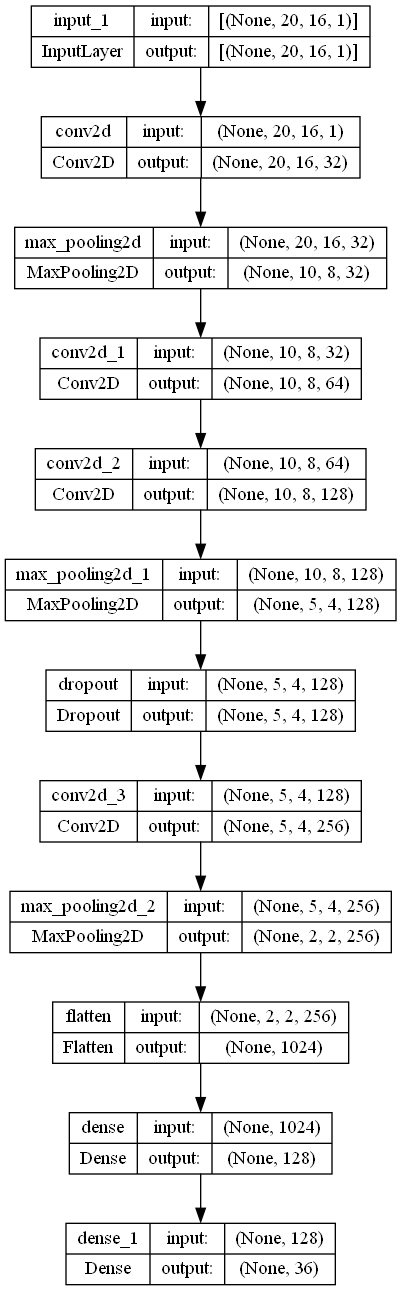

In [17]:
plot_model(model, show_shapes=True, expand_nested=True)

# Plotting train, test losses and accuracy

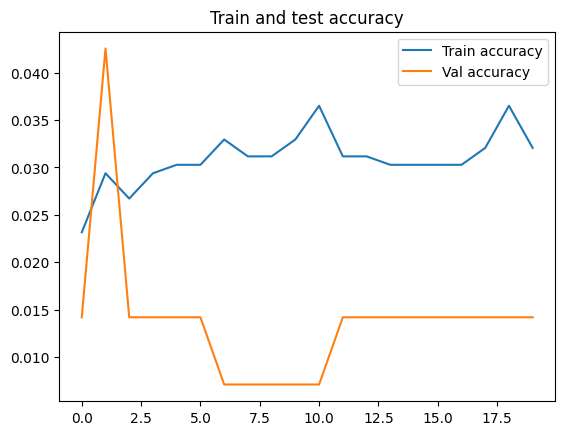

<Figure size 10000x10000 with 0 Axes>

In [18]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.title('Train and test accuracy')
plt.legend()
plt.figure(figsize = (100,100))
plt.show()

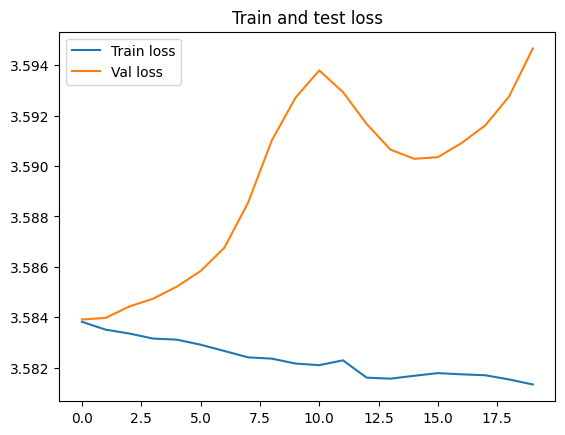

<Figure size 20000x20000 with 0 Axes>

In [19]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Val loss')
plt.title('Train and test loss')
plt.legend()
plt.figure(figsize = (200,200))
plt.show()